## Calibration of a line to data, running multiple chains in parallel

In [1]:
import rxmc

Using database version X4-2024-12-31 located in: /home/beyerk/db/exfor/unpack_exfor-2024/X4-2024-12-31


In [2]:
from collections import OrderedDict
import ipyparallel as ipp
import corner
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

## define parameters

In [3]:
params = [
    rxmc.params.Parameter("b", float, "y-units"),
    rxmc.params.Parameter("m", float, "no-units"),
]

## make the model

In [4]:
class LinearModel(rxmc.model.Model):
    def __call__(self, params: OrderedDict):
        return params["m"] * self.x + params["b"]

In [5]:
x = np.linspace(0, 1, 10)

In [6]:
my_model = LinearModel(x)

## define a prior

In [7]:
prior_mean = OrderedDict(
    [
        ("m", 1),
        ("b", 1),
    ]
)
prior_std_dev = OrderedDict(
    [
        ("m", 1),
        ("b", 1),
    ]
)

In [8]:
covariance = np.diag(list(prior_std_dev.values())) ** 2
mean = np.array(list(prior_mean.values()))

In [9]:
n_prior_samples = 100000
prior_distribution = stats.multivariate_normal(mean, covariance)
prior_samples = prior_distribution.rvs(size=n_prior_samples)

In [10]:
y = np.zeros((n_prior_samples, len(my_model.x)))
for i in range(n_prior_samples):
    sample = prior_samples[i, :]
    y[i, :] = my_model(rxmc.params.to_ordered_dict(sample, [p.name for p in params]))

upper, lower = np.percentile(y, [5, 95], axis=0)

Text(0.5, 1.0, 'prior')

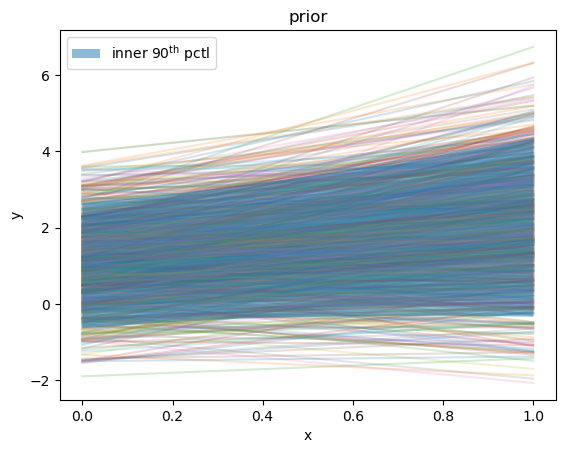

In [11]:
for i in np.random.choice(n_prior_samples, 1000):
    plt.plot(my_model.x, y[i, :], zorder=1, alpha=0.2)
    # pass

plt.fill_between(
    my_model.x, lower, upper, alpha=0.5, zorder=2, label=r"inner 90$^\text{th}$ pctl"
)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("prior")

Text(0.5, 0.98, 'prior')

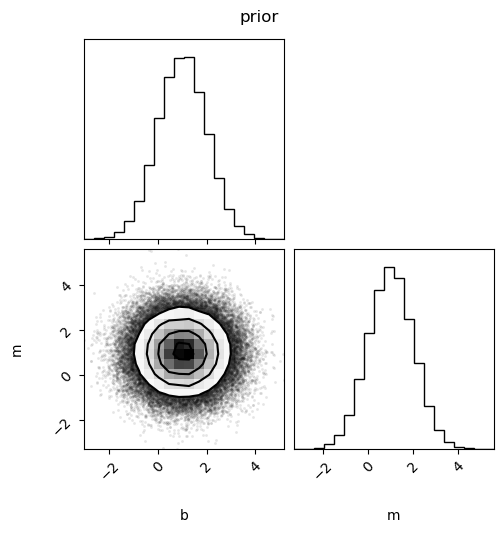

In [12]:
fig = corner.corner(prior_samples, labels=[p.name for p in params])
fig.suptitle("prior")

## find some data
In our case we will synthetically generate some data with noise about a "true" `m` and `b`. Our calibration posterior should converge to be centered about this true point.

Let us assume that the experimentalists made a perfect estimate of the experimental noise in their setup. That is, the error bars they report will correspond exactly to the true distribution from which we sample.

This noise will correspond to statistical noise. Later on we will look at systematic experimental error.

In [13]:
rng = np.random.default_rng(13)

Text(0.5, 1.0, 'experimental constraint')

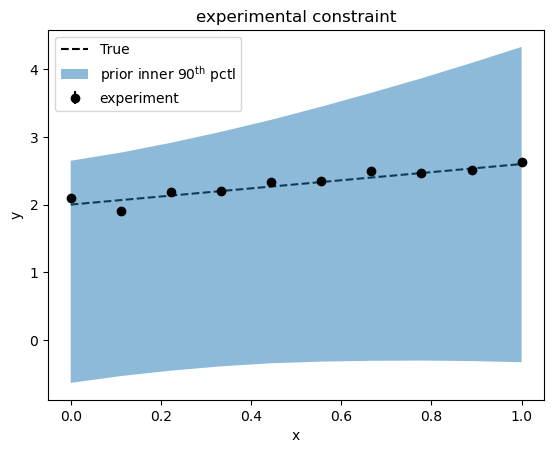

In [14]:
true_params = OrderedDict(
    [
        ("m", 0.6),
        ("b", 2),
    ]
)

noise = 0.05
y_exp = my_model(true_params) + rng.normal(scale=noise, size=len(my_model.x))
y_exp_err = noise * np.ones_like(y_exp)  # noise is just a constant fraction of y
plt.errorbar(
    my_model.x,
    y_exp,
    y_exp_err,
    color="k",
    marker="o",
    linestyle="none",
    label="experiment",
)
plt.plot(my_model.x, my_model(true_params), "k--", label=True)
plt.xlabel("x")
plt.ylabel("y")

plt.fill_between(
    my_model.x,
    lower,
    upper,
    alpha=0.5,
    zorder=2,
    label=r"prior inner 90$^\text{th}$ pctl",
)

plt.legend()
plt.title("experimental constraint")

## set up constraint

In [15]:
constraint = rxmc.constraint.FixedCovarianceConstraint(
    y_exp,
    np.diag(y_exp_err**2),
    my_model,
)

## running the calibration

In [16]:
corpus = rxmc.corpus.Corpus(
    [constraint],
    [p.name for p in params],
    "my_linear_model",
    "my_experimental_constraint",
)

In [17]:
%%time
# run a single chain
logl, chain, accepted_frac = rxmc.mcmc.run_chain(
    prior_distribution, corpus, nsteps=10000, burnin=1000, verbose=True
)

Rank: 0. Burn-in batch 1/1 completed, 1000 steps.
Rank: 0. Batch: 1/1 completed, 9000 steps. Acceptance frac: 0.111
CPU times: user 2.34 s, sys: 4.65 ms, total: 2.35 s
Wall time: 2.35 s


Text(0.5, 0, '$i$')

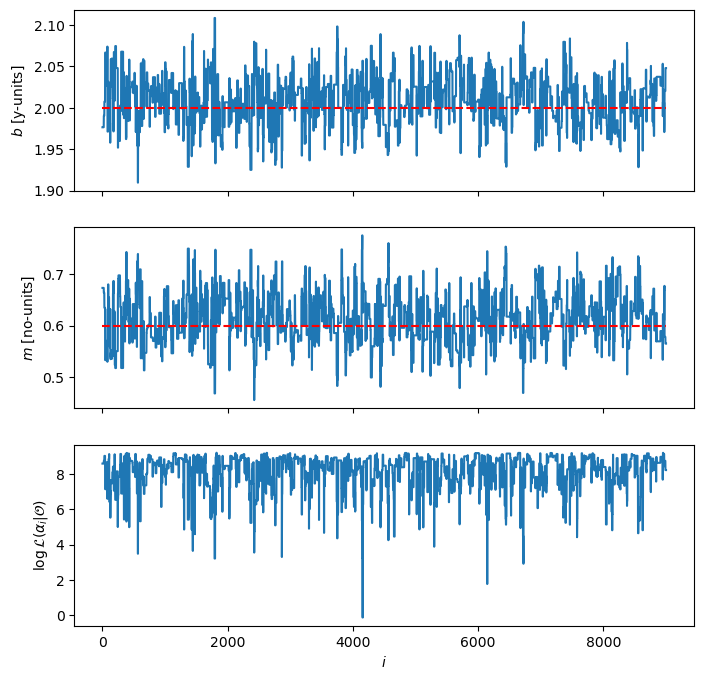

In [18]:
fig, axes = plt.subplots(chain.shape[1] + 1, 1, figsize=(8, 8), sharex=True)
for i in range(chain.shape[1]):
    axes[i].plot(chain[:, i])
    axes[i].set_ylabel(f"${params[i].latex_name}$ [{params[i].unit}]")
    true_value = true_params[params[i].name]
    axes[i].hlines(true_value, 0, len(chain), "r", linestyle="--")


axes[-1].plot(logl)
axes[-1].set_ylabel(r"$\log{\mathcal{L}(\alpha_i | \mathcal{O})}$")

axes[-1].set_xlabel(r"$i$")
# plt.legend(title="chains", ncol=3,)

In [19]:
posterior_range = np.vstack([np.min(chain, axis=0), np.max(chain, axis=0)]).T

In [20]:
true_params.values()

odict_values([0.6, 2])

Text(0.5, 0.98, 'posterior')

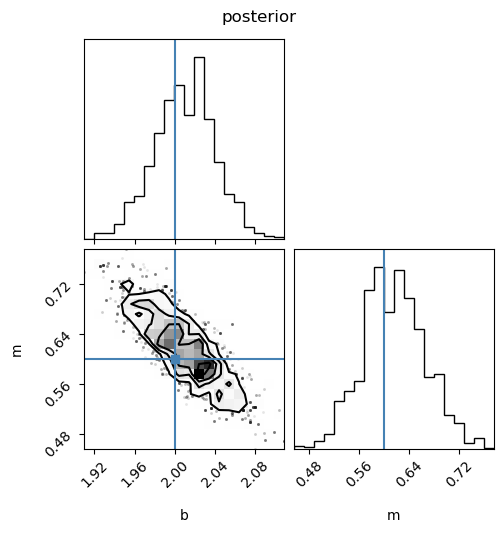

In [21]:
fig = corner.corner(
    chain,
    labels=[p.name for p in params],
    label="posterior",
    truths=[true_params["b"], true_params["m"]],
)
fig.suptitle("posterior")

In [22]:
n_posterior_samples = chain.shape[0]
y = np.zeros((n_posterior_samples, len(my_model.x)))
for i in range(n_posterior_samples):
    sample = chain[i, :]
    y[i, :] = my_model(rxmc.params.to_ordered_dict(sample, [p.name for p in params]))

upper, lower = np.percentile(y, [5, 95], axis=0)

Text(0.5, 1.0, 'predictive posterior')

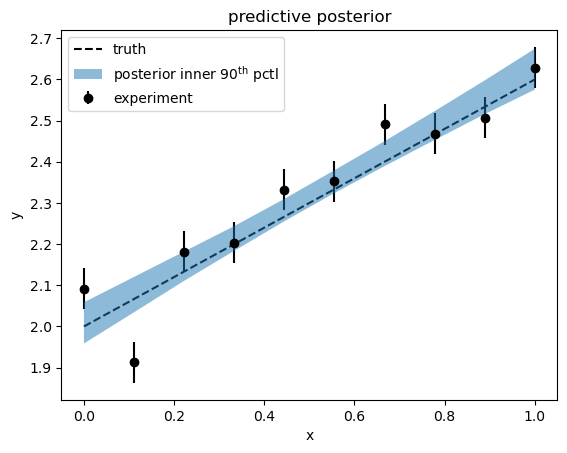

In [23]:
plt.plot(my_model.x, my_model(true_params), "k--", label="truth")
plt.xlabel("x")
plt.ylabel("y")
plt.errorbar(
    my_model.x,
    y_exp,
    y_exp_err,
    color="k",
    marker="o",
    linestyle="none",
    label="experiment",
)
plt.fill_between(
    my_model.x,
    lower,
    upper,
    alpha=0.5,
    zorder=2,
    label=r"posterior inner 90$^\text{th}$ pctl",
)

plt.legend()
plt.title("predictive posterior")

True applications should run multiple chains with different random seeds and starting locations to avoid autocorrelation within a chain.